# Script to Create Datasets, Models, and to Evaluate the Models

NB: The code below was used to fine-tune and evaluate all the models, however that is very time-consuming. Therefore, some of the comments in the code recommend changes that can be made (code that can be commented out or replaced with something else) to make the code run faster.

In [2]:
!pip install transformers datasets torch evaluate scikit-learn

You should consider upgrading via the 'C:\Users\Karoline\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, pipeline
import numpy as np
import evaluate
import sklearn

C:\Users\Karoline\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model parameters

In [3]:
model_name = 'NbAiLab/nb-bert-large'
max_seq_length = 128
batch_size = 32
warmup_proportion = 0.1
epochs = 3  

## Load and prepare data

In [4]:
imdb = load_dataset('imdb')
train_norec = load_dataset('csv', data_files='./norec_train_small.csv')
eval_norec = load_dataset('csv', data_files='./norec_eval_small.csv')
test_norec = load_dataset('csv', data_files='./norec_test.csv')

Found cached dataset imdb (C:/Users/Karoline/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.80it/s]
Using custom data configuration default-428935cb235bc209
Found cached dataset csv (C:/Users/Karoline/.cache/huggingface/datasets/csv/default-428935cb235bc209/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.94it/s]
Using custom data configuration default-db372433c7306bd9
Found cached dataset csv (C:/Users/Karoline/.cache/huggingface/datasets/csv/default-db372433c7306bd9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 59.91it/s]
Using custom data c

In [5]:
# Tokenize data

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=max_seq_length)

train_norec_encoding = train_norec.map(
    tokenize_function, 
    batched=True
)

test_norec_encoding = test_norec.map(
    tokenize_function, 
    batched=True
)

eval_norec_encoding = eval_norec.map(
    tokenize_function, 
    batched=True
)

imdb_encoding = imdb.map(
    tokenize_function, 
    batched=True
)

Loading cached processed dataset at C:/Users/Karoline/.cache/huggingface/datasets/csv/default-428935cb235bc209/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-de260e6381244414.arrow
Loading cached processed dataset at C:/Users/Karoline/.cache/huggingface/datasets/csv/default-12b3df2afc6b8387/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-c8a79f6062a07423.arrow
Loading cached processed dataset at C:/Users/Karoline/.cache/huggingface/datasets/csv/default-db372433c7306bd9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-fab6c5fb141cf83e.arrow
Loading cached processed dataset at C:/Users/Karoline/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-c86fbd2b1d158dec.arrow
 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:18<00:00,  1.28ba/s]
Loading cached processed dataset at C:/Users/Karo

#### IMDB dataset

In [6]:
# Also the IMDB dataset will only use 1000 examples for training, because of time constraints
final_train_imdb_encoding = imdb_encoding['train'].shuffle(seed=42).select(range(1000))
final_train_imdb_encoding

Loading cached shuffled indices for dataset at C:/Users/Karoline/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-9b48b79469815776.arrow


Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [7]:
# Evaluation dataset to use for evaluation while the model trains.
final_eval_imdb_encoding = imdb_encoding['test'].shuffle(seed=42).select(range(200))
final_eval_imdb_encoding

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

#### NoReC dataset

In [8]:
final_train_norec_encoding = train_norec_encoding['train']
final_train_norec_encoding

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [9]:
final_eval_norec_encoding = eval_norec_encoding['train']
final_eval_norec_encoding

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 200
})

In [10]:
final_test_norec_encoding = test_norec_encoding['train']
final_test_norec_encoding

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1429
})

## Create a model and fine-tune it on the IMDB dataset 

This model will not see the NoReC dataset during training, meaning that both an imdb dataset is used for training and for evaluation. 

In [62]:
def create_and_train_model(lr: float, path: str, training_data, eval_data) -> None:
    """
    Create a model based on a pretrained model, then fine-tune the model and save it to a file. 
    Args:
        lr: the learning rate to use. 
        path: the beginning of the folder path where the fine-tuned model should be saved
            (lr will be appended to the end of the path)
        training_data: training dataset (encoded) to use for fine-tuning
        eval_data: evaluation dataset (encoded) to use for evaluation during fine-tuning
    """
    # Create the model by getting the pre-trained one
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Create a trainer which specifies the training parameters
    training_args = TrainingArguments(
        output_dir='test_trainer',
        learning_rate = lr,
        warmup_steps = num_warmup_steps,
        evaluation_strategy='epoch'    
    )

    # Create a function to evaluate the training
    metric = evaluate.load('f1')

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=training_data,
        eval_dataset=eval_data,
        compute_metrics=compute_metrics,
    )

    # fine-tune
    trainer.train()

    # save the model to a folder so it can be used later
    directory = path + str(lr)
    tokenizer.save_pretrained(directory)
    model.save_pretrained(directory)

The paper by [Kummervold et al.](https://arxiv.org/abs/2104.09617) and [Devlin et al.](https://arxiv.org/abs/1810.04805) tried learning rates between 2e-5 and 5e-5, and therefore 4 different learning rates have been tried here too, and the results on the imdb evaluation dataset was used to determine what model should be used to make prediction on the NoReC test dataset.

The cell below takes many hours to run. Each fine-tuned model is saved to a file so it won't be have to run again. The model that performed the best was also uploaded to huggingface so it can more easily be accessed. I would recommend commenting out the whole cell below and just load the best model (with a learning rate of 5e-5) from hugging face when required (the code for this will be given when needed).

NB: the naming is a bit off. Things should have been named finetuned instead of pretrained, but I guess my brain failed when starting this naming convention, and it would take hours to rerun the code to fix file-names etc. so I will just leave it. 

In [1]:
# Unless you really want to run this whole cell again (takes hours), just look at the results below and 
# load the best model from huggingface when required. 
create_and_train_model(2e-5, './model_pretrained_on_imdb_dataset_', final_train_imdb_encoding, final_eval_imdb_encoding)
create_and_train_model(3e-5, './model_pretrained_on_imdb_dataset_', final_train_imdb_encoding, final_eval_imdb_encoding)
create_and_train_model(4e-5, './model_pretrained_on_imdb_dataset_', final_train_imdb_encoding, final_eval_imdb_encoding)
create_and_train_model(5e-5, './model_pretrained_on_imdb_dataset_', final_train_imdb_encoding, final_eval_imdb_encoding)

NameError: name 'create_and_train_model' is not defined

The results from funning the above cell is presented here.

The following output comes from lr=2e-5:
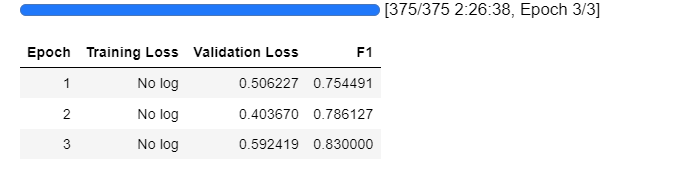

this is with lr=3e-5:
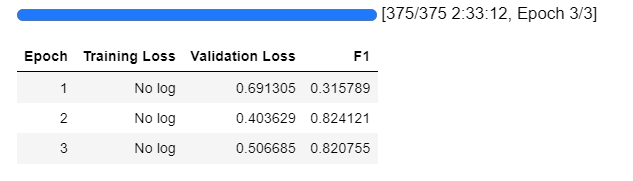

this is with lr=4e-5:
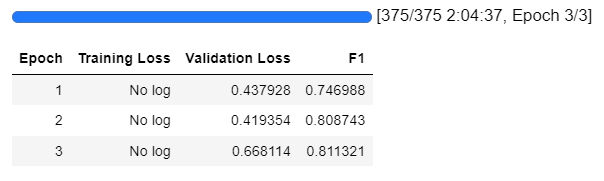

and this is with lr=5e-5:
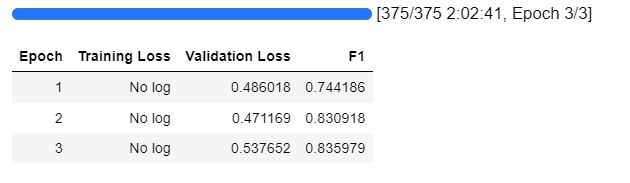

### Evaluate the model

In [56]:
def predict_from_fine_tuned_model(model_path: str, test_dataset_text: list[str]) -> pd.DataFrame:
    """
    Make prediction on a dataset using a fine-tuned model.
    Args:
        model_path: file path to the fine-tuned model that should be used
        test_dataset_text: a list containing the texts that sentiment analysis should be performed on
    Returns:
        a dataframe with the columns |Text|Label|Score| where the the text is the input text and the 
        label is the predicted label. The score is the probability that the label is correct. 
    """

    # Get the fine-tuned model
    fetched_model = AutoModelForSequenceClassification.from_pretrained(model_path)
    fetched_tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Create a classifier
    classifier = pipeline(task='sentiment-analysis', model=fetched_model, tokenizer=fetched_tokenizer)

    # The input can not be too big, set to the same size as used during fine-tuning
    tokenizer_kwargs = {'padding': True, 'truncation': True, 'max_length': max_seq_length}

    result = classifier(test_dataset_text, **tokenizer_kwargs)

    # Create a dataframe containing the results
    data = {
            'Text': test_dataset_text, 
            'Label': [d['label'] for d in result],
            'Score': [d['score'] for d in result]
           }
    result_df = pd.DataFrame(data)
    return result_df

In [43]:
def report_evaluation(predicted_labels_string: list[str], actual_labels: list[int]) -> None:
    """
    Evaluate the predictions made by the model, and print the evaluation.
    Args:
        result_df: a list containing the labels predicted by the model
        actual_labels: the actual labels of the dataset
    Returns:
        None
    """

    predicted_labels = []
    for prediction in predicted_labels_string:
        if prediction == 'LABEL_0':
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)

    print(sklearn.metrics.classification_report(actual_labels, predicted_labels))

#### IMDB

Here I will evaluate on the IMDB evaluation dataset, just to get a better idea of what of the pretrained models worked the best, however the actual validation will be done later on the NoReC test dataset. 

Based on the results below, plus the results seen during fine-tuning, there is not much difference when using different learning rates, but the one with a learning rate of 5e-5 seems to be a bit better than the others and will be used for testing. 

In [41]:
# Get the evaluation dataset
test_dataset = imdb['test'].shuffle(seed=42).select(range(200))
test_dataset_text = test_dataset['text']
test_dataset_labels = test_dataset['label']

Loading cached shuffled indices for dataset at C:/Users/Karoline/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1\cache-2eff9f118d84c6fe.arrow


In [44]:
# If you didn't run the code above that I suggested commenting out, comment out this as well, or it won't run
# since the models won't be found (they were not saved as files on the computer)
results_2e = predict_from_fine_tuned_model('./model_pretrained_on_imdb_dataset_2e-05', test_dataset_text)
predicted_labels_string_2e = results_2e['Label']
print('The results using a learning rate of 2e-05:')
report_evaluation(predicted_labels_string_2e, test_dataset_labels)

results_3e = predict_from_fine_tuned_model('./model_pretrained_on_imdb_dataset_3e-05', test_dataset_text)
predicted_labels_string_3e = results_3e['Label']
print('\nThe results using a learning rate of 3e-05:')
report_evaluation(predicted_labels_string_3e, test_dataset_labels)

results_4e = predict_from_fine_tuned_model('./model_pretrained_on_imdb_dataset_4e-05', test_dataset_text)
predicted_labels_string_4e = results_4e['Label']
print('\nThe results using a learning rate of 4e-05:')
report_evaluation(predicted_labels_string_4e, test_dataset_labels)

results_5e = predict_from_fine_tuned_model('./model_pretrained_on_imdb_dataset_5e-05', test_dataset_text)
predicted_labels_string_5e = results_5e['Label']
print('\nThe results using a learning rate of 5e-05:')
report_evaluation(predicted_labels_string_5e, test_dataset_labels)

The results using a learning rate of 2e-05:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       104
           1       0.80      0.86      0.83        96

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200


The results using a learning rate of 3e-05:
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       104
           1       0.75      0.91      0.82        96

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200


The results using a learning rate of 4e-05:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       104
           1       0.74      0.90      0.81        96

    accuracy                           0.80     

#### NoReC dataset - results

The model trained on the IMDB dataset with a learning rate of 5e-05 will be used to predict the sentiment of the NoReC test dataset, and the results will be printed. This model was saved to [huggingface](https://huggingface.co/karolill/nb-bert-finetuned-on-imdb?text=I+like+you.+I+love+you) so it can be easily loaded. The code to load this model from huggingface is also given below as a comment, in case you didn't want to run the code to fine-tune the models and create local files above.

In [58]:
norec_test_text = test_norec['train']['text']
norec_test_labels = test_norec['train']['label']

# If you didn't run the cell I recommended commenting out, uncomment the following line to load model from
# huggingface:
# results_pretrained_on_imdb = predict_from_fine_tuned_model('karolill/nb-bert-finetuned-on-imdb', norec_test_text)
# and comment out this line:
results_pretrained_on_imdb = predict_from_fine_tuned_model('./model_pretrained_on_imdb_dataset_5e-05', norec_test_text)
# Leave this line either way:
predicted_labels_string_norec_pretrained_on_imdb = results_pretrained_on_imdb['Label']

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [61]:
print('\nThe results on the NoReC dataset using a learning rate of 5e-05 is:')
report_evaluation(predicted_labels_string_norec_pretrained_on_imdb, norec_test_labels)


The results on the NoReC dataset using a learning rate of 5e-05 is:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       416
           1       0.86      0.92      0.89      1013

    accuracy                           0.84      1429
   macro avg       0.81      0.77      0.79      1429
weighted avg       0.83      0.84      0.83      1429



The model achieved an accuracy of 84% even though it was fine-tuned only on english texts. Otherwise, we can see that the model is better at predicting positive reviews than negative reviews. 

## Create a model and fine-tune it on the NoReC dataset

The above code fine-tuned a model on the IMDB dataset, and now a model will be fine-tuned on the NoReC dataset for comparison. Since a learning rate of 5e-5 worked best when fine-tuning on the IMDB dataset, that will also be used here. The model created here (finetuned on NoReC with a learning rate of 5e-5) is saved to [huggingface](https://huggingface.co/karolill/nb-bert-finetuned-on-norec?text=I+like+you.+I+love+you). 

In [63]:
# Also time-consuming. Can comment out this cell and an alternative code will be given where needed below, 
# since the model created by this cell is saved to huggingface
create_and_train_model(5e-5, './model_pretrained_on_norec_dataset_', final_train_norec_encoding, final_eval_norec_encoding)

Some weights of the model checkpoint at NbAiLab/nb-bert-large were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

Epoch,Training Loss,Validation Loss,F1
1,No log,0.530493,0.790123
2,No log,0.324948,0.917910
3,No log,0.170057,0.962963


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


Training complete

The f1 score during training was better when training on the NoReC dataset, and looked like this:
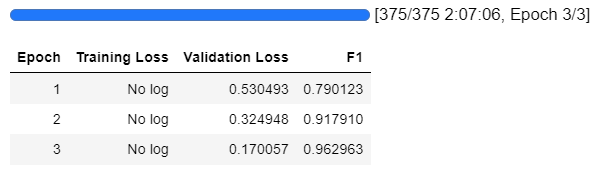

### Evaluate the model

#### NoReC dataset - results

The model fine-tuned on the NoReC dataset will be evaluated and the results printed.

In [64]:
# If you dropped the cell above that fine-tuned the model and saved it locally, uncomment this line:
# results_pretrained_on_norec = predict_from_fine_tuned_model('karolill/nb-bert-finetuned-on-norec', norec_test_text)
# and comment out this line:
results_pretrained_on_norec = predict_from_fine_tuned_model('./model_pretrained_on_norec_dataset_5e-05', norec_test_text)
# Let this line stay either way:
predicted_labels_string_norec_pretrained_on_norec = results_pretrained_on_norec['Label']

loading configuration file ./model_pretrained_on_norec_dataset_5e-05\config.json
Model config BertConfig {
  "_name_or_path": "./model_pretrained_on_norec_dataset_5e-05",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./model_pretrained_on_norec_dataset_5e-05\pytorch_model.bin
All model checkpoint weights were used when initializing Bert

In [66]:
print('\nThe results on the NoReC dataset using a learning rate of 5e-05 when the model was pretrained on the NoReC dataset is:')
report_evaluation(predicted_labels_string_norec_pretrained_on_norec, norec_test_labels)


The results on the NoReC dataset using a learning rate of 5e-05 when the model was pretrained on the NoReC dataset is:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       416
           1       0.88      0.89      0.89      1013

    accuracy                           0.84      1429
   macro avg       0.80      0.80      0.80      1429
weighted avg       0.83      0.84      0.84      1429



## Check how much the model knows before being fine-tuned

To get an idea of how important the fine-tuning process is, an experiment will be done to check how well the NB-BERT model performs without any fine-tuning. 

In [67]:
results_not_fine_tuned = predict_from_fine_tuned_model(model_name, norec_test_text)
predicted_labels_string_norec_not_fine_tuned = results_not_fine_tuned['Label']

loading configuration file config.json from cache at C:\Users\Karoline/.cache\huggingface\hub\models--NbAiLab--nb-bert-large\snapshots\27e8180855f0de03688958c88a2e5702bfbf0bfd\config.json
Model config BertConfig {
  "_name_or_path": "NbAiLab/nb-bert-large",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file pytorch_model.bin from cache at C:\Users\Karoline/.cache\huggingface\hub\models--NbAiLab--nb-bert-large\snapshots\27e8180855f0de03688958c88a2e5702bfbf0bfd\pytorch_model.bin


In [69]:
print('\nThe results on the NoReC dataset when not fine-tuning is done is:')
report_evaluation(predicted_labels_string_norec_not_fine_tuned, norec_test_labels)


The results on the NoReC dataset when not fine-tuning is done is:
              precision    recall  f1-score   support

           0       0.27      0.31      0.28       416
           1       0.70      0.65      0.67      1013

    accuracy                           0.55      1429
   macro avg       0.48      0.48      0.48      1429
weighted avg       0.57      0.55      0.56      1429

